# P5


In [1]:
import pandas as pd
import numpy as np

import pickle

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.filterwarnings('ignore')

In [2]:

docs = pd.read_csv("QueryResults.csv")

In [3]:
docs.set_index('Id').sort_index()

,Title,Body,Tags,Score,ViewCount,FavoriteCount,AnswerCount
Id,,,,,,,
4,How to convert a Decimal to a Double in C#?,<p>I want to use a <code>Track-Bar</code> to c...,<c#><floating-point><type-conversion><double><...,759,64063,58,12
11,Calculate relative time in C#,<p>Given a specific <code>DateTime</code> valu...,<c#><datetime><time><datediff><relative-time-s...,1612,188799,552,41
13,Determine a user's timezone,<p>Is there a standard way for a web server to...,<html><browser><timezone><user-agent><timezone...,673,248432,157,27
19,What is the fastest way to get the value of π?,<p>I'm looking for the fastest way to obtain t...,<performance><algorithm><language-agnostic><un...,341,63943,86,23
88,Is gettimeofday() guaranteed to be of microsec...,"<p>I am porting a game, that was originally wr...",<linux><winapi><visual-c++><unix><timer>,104,43767,19,10
...,...,...,...,...,...,...,...
69729326,Endless sine generation in C,<p>I am working on a project which incorporate...,<c><performance><time><precision><trigonometry>,91,10074,25,12
69832748,"Error ""Error: A <Route> is only ever to be use...",<p>I am trying to use routing for the first ti...,<javascript><node.js><reactjs><frameworks><rea...,57,77406,13,14
69875125,find_element_by_* commands are deprecated in s...,<p>When starting the function</p>\n<pre><code>...,<python><selenium><selenium-webdriver><webdriv...,52,59346,25,3


In [4]:
docs.drop(['Id', 'Score', 'ViewCount', 'FavoriteCount','AnswerCount'], axis=1, inplace=True)

## Data Preparation


### Tags preprocessing

In [5]:
# tokenize the tags
def tokenizeTags(tags):
    """
    Remove some unwanted characters
    """
    tags = tags.replace('<', ' ')
    tags = tags.replace('>', '')
    return tags.strip().split(' ')

docs['Tags'] = docs['Tags'].apply(tokenizeTags)

In [6]:
# one doc tags sample
docs['Tags'][0]

['javascript', 'geolocation', 'projection', 'processing.js', 'proj4js']

In [8]:
# get 200 most frequent tags
def getMostFrequentTags(df: pd.DataFrame, col: str, max_tags_count = 200) -> pd.DataFrame:
    all_tags = [item for sublist in df[col] for item in sublist]
    unique, counts = np.unique(all_tags, return_counts=True)
    return pd.DataFrame({'word': unique, 'count':counts}).sort_values('count', ascending=False)[:max_tags_count]

currated_tags = getMostFrequentTags(docs, 'Tags').word.values

In [9]:
# filter tags of each document to restrict to most common
def get_most_tag(row):
    return [ tag for tag in row if tag in currated_tags]

docs['tags'] = docs['Tags'].apply(get_most_tag)

In [10]:
docs.drop('Tags', axis=1, inplace=True)

### Word Cloud

'0                                      [javascript]\n1                                             [c++]\n2                                  [c#, .net, linq]\n3             [c++, performance, optimization, stl]\n4                                         [c, file]\n                            ...                    \n27123             [javascript, reactjs, typescript]\n27124                                  [linux, wpf]\n27125                          [python, python-3.x]\n27126                  [python, python-3.x, string]\n27127    [python, memory-management, deep-learning]\nName: tags, Length: 27128, dtype: object'

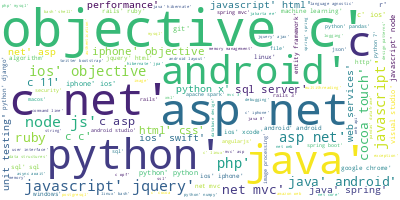

In [27]:
# TODO WIP
from wordcloud import WordCloud

words = str([tag for row in docs.tags for tag in row])
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=200, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(words)
# Visualize the word cloud
wordcloud.to_image()

### Words preprocessing

In [28]:
# add title into the body
docs['body'] = docs['Title'] + '\n' + docs['Body']

#### Remove code snippets

In [30]:
from bs4 import BeautifulSoup

def remove_code_snippets(docs):
    """
    Remove code snippets from docs
    surrounded by <pre> tags
    """
    # ensure '<' & '>' chars are set, not the unicode char
    docs = docs.apply(lambda d: d.replace('&lt;', '<').replace('&gt;', '>'))
    ret = []
    for doc in docs:
        soup = BeautifulSoup(doc, 'html.parser')
        removals = soup.find_all('pre')
        for pre in removals:
            pre.decompose()
        ret.append(soup.get_text())
    return ret


In [32]:
docs.body = remove_code_snippets(docs.body)

#### Remove Stop words, Lemmatize, Stemmize, Tokenize

In [33]:
# remove stop words
# lemmatize (convert and remove prefixes and suffixes to ignore the gender, plural, verb : walking, walks, walked, walk -> walk)
# and/or stemmize (take the same root of words : universal / university -> univers)

import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import EnglishStemmer
from nltk.stem import WordNetLemmatizer

stopwords = set(stopwords.words('english'))
filtre_stopw =  lambda text: [token.lower() for token in text if token.lower() not in stopwords]

# replace words with stem
def tokenize_sw_stem(doc):
    tokenizer = nltk.RegexpTokenizer(r'\w+')
    stemmer = EnglishStemmer()
    filtered = filtre_stopw(tokenizer.tokenize(doc))
    ret = " ".join([stemmer.stem(s) for s in filtered] )
    return ret

# replace words with lem
def tokenize_sw_lem(doc):
    lemmatizer = WordNetLemmatizer()
    filtered = filtre_stopw(nltk.tokenize.word_tokenize(doc))
    # filtered = filtre_stopw(tokenizer.tokenize(doc))
    ret = " ".join([lemmatizer.lemmatize(s) for s in filtered] )
    # removes punctuation, comes from string.punctuation, without some special characters present into the tags (c#, c++, objective-c, )
    ret = ret.translate(str.maketrans('', '', r"""!"$%&'()*,./:;<=>?@[\]^_`{|}~"""))
    # manage c# token
    ret = re.sub(r'c #', 'c#', ret)
    # TODO manage .net token
    # remove double spaces
    ret = re.sub(r' {2,}', ' ', ret)
    # remove single char, except 'c', 'r'
    ret = re.sub(r'\s[abd-qs-z]{1}\s', '', ret)
    return ret


# words_stem = list(map(tokenize_sw_stem, docs.body))
# words_lem = list(map(tokenize_sw_lem, docs.body))


In [34]:
tokenize_sw_lem(docs.body[4733])

'c++ member variable aliaspretty sure possiblepretty sure ve seen done think awesome gladly accept answer along line terrible idea say basic struct want implement alias variable ideally third syntax would indistinguishable array sent arr reference parameter function expecting array float store data eg many opengl glget function would work fine think possible possible stupid '

In [17]:
docs.body[15]

'What are the differences between Generics in C# and Java... and Templates in C++?\nI mostly use Java and generics are relatively new. I keep reading that Java made the wrong decision or that .NET has better implementations etc. etc.\nSo, what are the main differences between C++, C#, Java in generics? Pros/cons of each?\n'

In [18]:
# let's choose the lemmatize version of the corpus, since it results in real words that could be used as tags
docs['tokenized_body'] = list(map(tokenize_sw_lem, docs.body))

In [19]:
## testing : maybe lemmatize leaves too much words, consider using stemming instead ?
s = docs.tokenized_body[docs.tokenized_body.str.contains('accordingly') ]
s = 'achieve'
lemmatizer.lemmatize(s)
stemmer.stem(s)

'achieve'

'achiev'

In [20]:
#  sandbox test
# currated_tags['stem_tag'] = [lemmatizer.lemmatize(word) for word in currated_tags.word]

#### Remove bad words


In [21]:
# test
re.sub(r'[0-9]+', '', docs.tokenized_body[4733])
# words tha contains underscores
re.sub(r'_+', '', docs.tokenized_body[4733])
# words_lem[0]

'c++ member variable aliaspretty sure possiblepretty sure ve seen done think awesome gladly accept answer along line terrible idea say basic struct want implement alias variable ideally third syntax would indistinguishable array sent arr reference parameter function expecting array float store data eg many opengl glget function would work fine think possible possible stupid '

'c++ member variable aliaspretty sure possiblepretty sure ve seen done think awesome gladly accept answer along line terrible idea say basic struct want implement alias variable ideally third syntax would indistinguishable array sent arr reference parameter function expecting array float store data eg many opengl glget function would work fine think possible possible stupid '

In [22]:
import re

def remove_words(words):
    ret = []
    for word in words:
        # print(f'\nprocessing sentence: {word}\n')
        flat = re.sub(r'[0-9]+', '', word) # words that are numbers
        flat = re.sub(r'_+', '', flat) # words tha contains underscores
        flat = re.sub(r'\w{15,}', '', flat) # words longer than 15 chars are most probably code (i.e. myClass.myMethodName())
        flat = " ".join(flat.split()) # remove double spaces
        # print(f'\ncurrated : {flat}')
        ret.append(flat)
    return ret


In [23]:
docs.tokenized_body = remove_words(docs.tokenized_body)


## Tags : MultiLabel Binarizer

In [75]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()

#deprecated - to remove
def mlb_tags_old(docs):
    docs[['tag0', 'tag1', 'tag2', 'tag3', 'tag4']] = docs['Tags'].str.split(expand=True)
    appended_tags = docs['Tags'].str.split(expand=True).stack()
    light_tag_list = appended_tags.value_counts()[:200]
    # fit the mlb with common tags (200)
    mlb.fit([light_tag_list.index])
    print(mlb.classes_.shape)
    docs['mlb_tags'] = mlb.transform(docs[['tag0', 'tag1', 'tag2', 'tag3', 'tag4']].values).tolist()

def mlb_tags(docs):
    mlb1 = MultiLabelBinarizer()
    # fit the mlb with common tags (200)
    mlb1.fit(docs.tags)
    print(mlb1.classes_.shape)
    docs['mlb_tags'] = mlb1.transform(docs.tags).tolist()
    return mlb1

def mlb_body(docs):
    mlb1 = MultiLabelBinarizer()
    mlb1.fit([docs.reduced_body])
    print(mlb1.classes_.shape)
    docs['mlb_reduced_body'] = mlb1.transform(docs.reduced_body).tolist()
    return mlb1


In [28]:
mlb_tags(docs)

(200,)


## Corpus size and Vocabulary

In [31]:
# count the total number of words in the overall corpus
# ideally would to be limited to 2000 / 3000 words maximum
lem = map(lambda x : x.split(), docs.tokenized_body)
flat_list = [word for sublist in list(lem) for word in sublist ]
len(flat_list)

unique, counts = np.unique(flat_list, return_counts=True)
counted_words = pd.DataFrame({'word': unique, 'count': counts}).sort_index(ascending=False)
counted_words

1771561

,word,count
80641,𩷶,1
80640,𨭎,1
80639,𤭢,2
80638,𠬠,1
80637,🤔,2
...,...,...
4,#haskelllisp,1
3,#decided,1
2,#able,1
1,##,1


In [32]:
MIN_COUNTS = 3000
df = pd.DataFrame({'count': counts, 'word': unique})
# take the 3000 most used words in the corpus for our vocabulary
dff = df.sort_values('count', ascending=False)[:MIN_COUNTS]
vocabulary = dff.word.values
len(vocabulary)

3000

In [33]:
# vocabulary
# currated_tags.word.values
np.append(vocabulary, currated_tags.word.values)

array(['nt', 'using', 'use', ..., 'encryption', 'configuration', 'dom'],
      dtype=object)

In [34]:
# now let's reduce our corpus to the restricted vocabulary
# df['reduced_body'] 
# docs.tokenized_body[0].split(' ').isin(vocabulary)

def reduce_body(body):
    ret = []
    for word in body.split(' '):
        if word in np.append(vocabulary, currated_tags.word.values):
            ret.append(word)
    return ' '.join(ret)


ret = reduce_body(docs.tokenized_body[1])
ret


'starting point learning file format developing analysis software move rectangle box real model still little idea start software going build make calculation import solid body software model solid body represented possibility step format eg complete understand without knowing basic concept c++ library import solid body file format wo nt difficult build complete model able import file'

In [35]:

# docs['reduced_body'] = docs.tokenized_body.apply(reduce_body)

docs['reduced_body'] = [reduce_body(body) for body in docs.tokenized_body]


In [76]:
mlb = mlb_body(docs)

(27128,)


In [74]:
mlb.classes_
np.unique(docs.reduced_body[0].split())
# docs.mlb_reduced_body[0]
df = pd.DataFrame(mlb.transform(['able']).T)
df[df[0] == 1]

array([' ', '#', '+', '-', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i',
       'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v',
       'w', 'x', 'y', 'z', '–', '—', '‘', '’', '“', '”'], dtype=object)

array(['able', 'accurate', 'also', 'another', 'anyone', 'appreciate',
       'around', 'bounding', 'box', 'ca', 'code', 'could', 'enough',
       'example', 'explaining', 'figure', 'find', 'get', 'good', 'got',
       'greatly', 'help', 'however', 'implement', 'including', 'latitude',
       'longitude', 'managed', 'map', 'nt', 'onto', 'plot', 'point',
       'projection', 'put', 'resource', 'solve', 'successfully', 'taking',
       'thanks', 'use', 'using', 'value', 'whole', 'work', 'world',
       'would'], dtype='<U12')

,0
4,1
5,1
8,1
15,1


## Train, Test Sets

In [ ]:
from sklearn.model_selection import train_test_split

X = docs.reduced_body
y = docs.mlb_tags

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

## Bag Of Words / Tf-Idf 

Bag of words uses CounVectorizer, then we look for the most frequent word to suggest a tag

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer()
bow = cv.fit_transform(X)


In [ ]:

bow.todense().max
cv.get_feature_names_out()

Tf-idf takes the frequency of a word from a sentence in a context of a corpus, then we take the most frequent words to suggest a tag

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer


vectorizer = TfidfVectorizer(vocabulary=vocabulary, ngram_range=(1, 2))
vectorizer.fit(docs['reduced_body'])
vectorizer.get_feature_names_out()


In [ ]:
with open('vectorizer', 'wb') as v :
    pickle.dump(vectorizer, v)


#### Prediction method for tf-idf

In [ ]:
# predicition - nouvelle methode
# TODO optimize  - temps de calcul trop long ~ 3'30

def predict_tfidf(doc, filter_tags=True) -> list[str]:
    """
    Returns a list of tags representative to the document provided, predicted from tf-idf

    Parameters
    ----------
    doc: iterable
        a list of words to compute tf-idf
    
    filter_tags: boolean
        defines if returned tags must be part of a currated list of tags
    
    Returns
    -------
    ret : a list of strings, may be empty

    """
    res = vectorizer.transform([doc]).T.todense()
    res = pd.DataFrame({'tfidf': res.tolist()}).sort_values('tfidf', ascending=False)[:5]
    res = [ vectorizer.get_feature_names_out()[found_tag_index] for found_tag_index in res.index]    
    # print(f'found tags from tfidf: {res}')
    if (not filter_tags):
        return res
    else:
        return [tag for tag in res if tag in currated_tags.word.values ]


# test
index = 2
docs.reduced_body[index]
predict_tfidf(docs.reduced_body[index], False) #show all tags found
predict_tfidf(docs.reduced_body[index]) # show only tags found which are part of currated tags (list of 200)


In [ ]:

docs['predicted_tags_tfidf'] = [predict_tfidf(doc) for doc in docs.reduced_body]


In [ ]:
# TODO : mlb is not traine don reduced_body !
# compute mlb of predicted tags
# docs['mlb_tags_pred_tfidf'] = [mlb.transform([tags]) for tags in docs.predicted_tags_tfidf]
docs['mlb_tags_pred_tfidf'] = mlb.transform(docs.predicted_tags_tfidf).tolist()


In [ ]:
len(mlb.classes_.tolist())
# docs.mlb_tags_pred_tfidf[0]

#### Multi-label scoring

<https://medium.datadriveninvestor.com/predicting-tags-for-the-questions-in-stack-overflow-29438367261e>

<https://towardsdatascience.com/evaluating-multi-label-classifiers-a31be83da6ea>



In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score

y_true = mlb.transform(docs.tags).tolist()
y_pred = mlb.transform(docs.predicted_tags_tfidf).tolist()

accuracy_score(y_true, y_pred)
average_precision_score(y_true, y_pred)
# recall_score(y_true, y_pred, average='macro')
print(classification_report(y_true, y_pred, target_names=mlb.classes_))

### Conclusion

Using tf-idf is not really performant to predict relevant tags (F1 score is way lower than 1)

| Score | value|
|--------|-------|
| Precision score | 0.41|
| Recall score | 0.23|
| f1-score | 0.26|


average parameter is required for multiclass/multilabel targets.

```
'None' : the scores for each class are returned. Otherwise, this determines the type of averaging performed on the data:

'micro': Calculate metrics globally by counting the total true positives, false negatives and false positives.

'macro': Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.

'weighted': Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance; it can result in an F-score that is not between precision and recall.
```

Plus le recall est haut, plus le modèle repère de positif.

Plus la precision est haute, moins le modèle se trompe sur les positifs

Le F1 Score permet d’effectuer une bonne évaluation de la performance de notre modèle

reminder : <https://inside-machinelearning.com/recall-precision-f1-score/>

## LDA

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=200, random_state=0)
lda.fit(vocabulary)

In [45]:
lda.transform(mlb.transform(docs.reduced_body).tolist())

array([[0.00166667, 0.00166667, 0.00166667, ..., 0.00166667, 0.00166667,
        0.00166667],
       [0.00166667, 0.00166667, 0.00166667, ..., 0.00166667, 0.00166667,
        0.00166667],
       [0.00166667, 0.00166667, 0.00166667, ..., 0.00166667, 0.00166667,
        0.00166667],
       ...,
       [0.00166667, 0.00166667, 0.00166667, ..., 0.00166667, 0.00166667,
        0.00166667],
       [0.00166667, 0.00166667, 0.00166667, ..., 0.00166667, 0.00166667,
        0.00166667],
       [0.00166667, 0.00166667, 0.00166667, ..., 0.00166667, 0.00166667,
        0.00166667]])

## Word2Vect

In [41]:
# snippet taken from sample notebook
import gensim
import multiprocessing
from gensim.models import Word2Vec

sentences = [ docs.split() for docs in docs.reduced_body]

print("Build & train Word2Vec model ...")
w2v_model = Word2Vec(sentences, min_count=1,vector_size=200, workers=multiprocessing.cpu_count())
# w2v_model.build_vocab(sentences)
# w2v_model.train(sentences, total_examples=1, epochs=1)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

Build & train Word2Vec model ...
Vocabulary size: 3037
Word2Vec trained


In [42]:
# training another model, will give slightly different results

model = Word2Vec(sentences, min_count=1, vector_size=200, workers=multiprocessing.cpu_count())
# model.build_vocab(sentences)
# model.train(sentences, total_examples=1, epochs=1)
# model.wv.index_to_key
print("Vocabulary size: %i" % len(model.wv.index_to_key))

Vocabulary size: 3037


In [43]:
# guess close words
len(model.wv.index_to_key)
guess = 'java'
model.wv[guess]
model.wv.most_similar(guess)
w2v_model.wv[guess]
w2v_model.wv.most_similar(guess)

3037

array([-0.58557546, -1.1354102 ,  0.12046065,  0.59639007, -0.45297256,
       -0.08538836, -1.0288872 , -0.07502311,  0.34875378,  1.456882  ,
        0.02904   ,  0.3484971 ,  0.8561433 ,  0.44659573,  0.21644755,
       -0.67796785, -0.28746688, -0.79099214, -0.89820534,  0.33728933,
        0.01065614,  0.05802602,  0.52821654, -0.4307533 ,  1.4652115 ,
        0.40524253,  0.2742625 , -1.0524437 , -0.22509259,  0.6129267 ,
        0.7393892 ,  1.0600578 ,  0.03563976,  0.39282697, -1.088671  ,
        0.18768804, -0.88462496,  0.34919947, -0.39016986, -1.9281803 ,
       -0.7560163 , -0.4093855 , -0.12985916,  0.11784337,  0.2488027 ,
       -0.5095998 ,  0.34837845, -0.620043  ,  0.22599325,  0.8957733 ,
        1.5080509 , -1.3247198 ,  0.94050956,  0.48689887, -0.6084543 ,
       -0.68195045, -0.246007  ,  0.7372067 , -0.51015025, -0.08187965,
       -0.33196554, -1.0757642 , -1.3153936 , -0.5359754 ,  0.9020954 ,
        0.32251906,  0.78391486,  0.93809205,  0.74706566, -0.82

[('ee', 0.7697761058807373),
 ('scala', 0.6680197715759277),
 ('swing', 0.5824506878852844),
 ('clojure', 0.5337738990783691),
 ('kotlin', 0.5332742929458618),
 ('jdk', 0.5242394208908081),
 ('jboss', 0.5157983303070068),
 ('c#', 0.5032386183738708),
 ('cc++', 0.5027136206626892),
 ('jni', 0.4903098940849304)]

array([-0.52990884, -1.0066278 ,  0.25581354,  1.3836367 , -0.49463156,
       -0.21418215, -0.27241096,  0.77627134,  0.6285232 ,  1.3047533 ,
        0.02917864,  0.536986  ,  0.2684114 , -0.25338364, -0.40457472,
       -0.21228805, -0.4150675 , -0.66024923, -0.16639598,  0.3857961 ,
       -0.2543728 ,  0.14833833,  0.39891765, -0.79374015,  1.5856831 ,
        0.23168905, -0.25601336, -0.8900388 ,  0.6595844 ,  0.4509691 ,
        0.5156059 ,  0.7576896 ,  0.47992414, -0.06808856, -0.77450997,
       -0.29349303, -1.1878793 , -0.32424703, -0.02394585, -2.115284  ,
        0.00647559, -0.5236665 , -0.18572758,  0.33532807, -0.7628372 ,
       -1.0393735 ,  0.13922833, -0.13380443,  0.11398205,  0.8548549 ,
        1.739255  , -1.1436307 ,  1.0189074 ,  0.23138583, -0.9459974 ,
       -1.0086391 ,  0.28035676,  0.8386735 , -0.11423967,  0.07597468,
       -0.38157305, -0.5324276 , -1.0570855 , -0.31051698,  0.55488914,
        0.2617658 ,  0.41912267,  0.21883406,  0.3338311 , -0.35

[('ee', 0.8012250661849976),
 ('scala', 0.6843573451042175),
 ('swing', 0.6296717524528503),
 ('kotlin', 0.5472506284713745),
 ('cc++', 0.5280548334121704),
 ('clojure', 0.5243746042251587),
 ('c#', 0.5197808742523193),
 ('jvm', 0.5111938714981079),
 ('jni', 0.4784856140613556),
 ('pure', 0.4744231402873993)]

In [44]:
with open('w2v_model', 'wb') as v :
    # pickle.dump(w2v_model, v)
    w2v_model.save(v)


### Averaged vector for documents

In [45]:
# compute average vector for each document
averaged_docs = [np.mean([w2v_model.wv[word] for word in doc.split()], axis=0) for doc in docs.reduced_body ]
# averaged_docs
docs['wv_averaged_doc'] = averaged_docs

In [46]:
#

### Clusterize embeded documents

*** last update ***

In [ ]:
from sklearn.cluster import KMeans


X = averaged_docs
kmeans = KMeans(n_clusters=200, random_state=0).fit(X)

kmeans.labels_

# kmeans.predict([[0, 0], [12, 3]])

# kmeans.cluster_centers_


In [49]:
len(averaged_docs[0])


200

In [ ]:
# TODO classify 
# calculer le doc2vect ? --> le vecteur pour un document, pas pour juste les mots
# faire une reduction de dimension PCA
# faire un KMeans pour trouver des clusters


## Appendix

In [ ]:
# vectorize a whole doc
def vectorize(list_of_docs, model):
    """Generate vectors for list of documents using a Word Embedding

    Args:
        list_of_docs: List of documents
        model: Gensim's Word Embedding

    Returns:
        List of document vectors
    """
    features = []

    for tokens in list_of_docs:
        zero_vector = np.zeros(model.vector_size)
        vectors = []
        for token in tokens:
            if token in model.wv:
                try:
                    vectors.append(model.wv[token])
                except KeyError:
                    continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            features.append(avg_vec)
        else:
            features.append(zero_vector)
    return features
    
vectorized_docs = vectorize(docs.reduced_body, model=w2v_model)
len(vectorized_docs), len(vectorized_docs[0])

(27128, 200)

In [ ]:
vectorized_docs

27128

In [ ]:
import sklearn.metrics as metrics

#  from https://www.kaggle.com/code/michaelfumery/stackoverflow-questions-tag-generator/notebook?scriptVersionId=68023262

def metrics_score(model, df, y_true, y_pred):
    """Compilation function of metrics specific to multi-label
    classification problems in a Pandas DataFrame.
    This dataFrame will have 1 row per metric
    and 1 column per model tested. 

    Parameters
    ----------------------------------------
    model : string
        Name of the tested model
    df : DataFrame 
        DataFrame to extend. 
        If None : Create DataFrame.
    y_true : array
        Array of true values to test
    y_pred : array
        Array of predicted values to test
    ----------------------------------------
    """
    if(df is not None):
        temp_df = df
    else:
        temp_df = pd.DataFrame(index=["Accuracy", "F1",
                                      "Jaccard", "Recall",
                                      "Precision"],
                               columns=[model])
        
    scores = []
    scores.append(metrics.accuracy_score(y_true, 
                                         y_pred))
    scores.append(metrics.f1_score(y_pred, 
                                   y_true, 
                                   average='weighted'))
    scores.append(metrics.jaccard_score(y_true, 
                                        y_pred, 
                                        average='weighted'))
    scores.append(metrics.recall_score(y_true, 
                                       y_pred, 
                                       average='weighted'))
    scores.append(metrics.precision_score(y_true, 
                                          y_pred, 
                                          average='weighted'))
    temp_df[model] = scores
    
    return temp_df

à lire


topic modelling : unsupervised learning

topic classification : supervised learning


<https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/>

<https://www.baeldung.com/cs/ml-word2vec-topic-modeling>

<https://medium.com/le-blog-de-lapprentissage-automatique/pr%C3%A9diction-des-tags-des-questions-de-stack-overflow-9be00f7672f9>

